# Antimony Reaction to ODE Functions

In [1]:
import sympy as sp
import numpy as np

def reactions_to_ode_func(reactions, species, parameters):
    # Create symbolic variables
    species_syms = {s: sp.Symbol(s) for s in species}
    param_syms = {p: sp.Symbol(p) for p in parameters}
    
    # Initialize derivative expressions
    derivs = {s: 0 for s in species}

    for rxn in reactions:
        # Format: "A + B -> C + D; rate_expr"
        reaction_part, rate_expr = map(str.strip, rxn.split(";"))
        rate = sp.sympify(rate_expr, locals={**species_syms, **param_syms})
        
        if "<->" in reaction_part:
            raise NotImplementedError("Reversible reactions not yet supported.")
        reactants_str, products_str = map(str.strip, reaction_part.split("->"))
        reactants = [r.strip() for r in reactants_str.split("+") if r.strip()]
        products = [p.strip() for p in products_str.split("+") if p.strip()]
        
        # Update derivatives
        for r in reactants:
            derivs[r] -= rate
        for p in products:
            derivs[p] += rate

    # Convert expressions to list in species order
    dydt_exprs = [derivs[s] for s in species]
    
    # Lambdify
    dydt_func = sp.lambdify((list(species_syms.values()), list(param_syms.values())), dydt_exprs, modules="numpy")

    # Define final ODE function
    def func(y, t, *params):
        return np.array(dydt_func(y, params)).flatten()

    return func


## Example

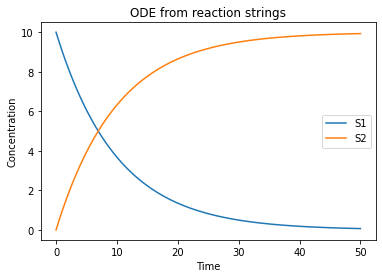

In [2]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

reactions = ["S1 -> S2; k1*S1"]
species = ["S1", "S2"]
parameters = ["k1"]
y0 = [10, 0]
t = np.linspace(0, 50, 100)
k1 = 0.1

func = reactions_to_ode_func(reactions, species, parameters)
sol = odeint(func, y0, t, args=(k1,))

# Plot
for i, s in enumerate(species):
    plt.plot(t, sol[:, i], label=s)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("ODE from reaction strings")
plt.show()

## Integrate with ModelBuilder

In [3]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [4]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [5]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

In [6]:
import os 

### parameters 
notebook_name = 'generate_large_model'
sub_id = '1'

## Generation of ground truth model 
model_name = 'v3_small_model_52'
o_random_seed = 6 
parameter_random_seed = 6
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 
simulation_time = 500 
simulation_step = 100

## Feature data generation 
feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 
'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
'''

# Engineering Feature Data 
data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + sub_id
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/generate_large_model_1/


In [28]:
### Generate the ground truth model
model_name = 'example_model'
seed = 5
parameter_random_seed = 5
num_species = 50
num_feedback = 2

model_spec = ModelSpecification()
model_spec.generate_specifications(seed, num_species, num_feedback, verbose=0)

In [29]:
G0 = model_spec.generate_network(model_name, specie_value_range, param_range, param_multiplier_range, random_seed=parameter_random_seed, verbose=0)

In [30]:
import re


def parse_antimony_model_fixed(antimony_str):
    reactions = []
    species_set = set()
    species_dict = {}
    parameter_dict = {}

    for line in antimony_str.splitlines():
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        if line.startswith("model ") or line == "end":
            continue

        # Reaction line
        if ":" in line and ";" in line:
            _, rxn = line.split(":", 1)
            rxn = rxn.strip()
            reactions.append(rxn)

            # Capture species from reaction components
            reaction_part, _ = map(str.strip, rxn.split(";"))
            if "->" in reaction_part:
                lhs, rhs = map(str.strip, reaction_part.split("->"))
                reactants = [s.strip() for s in lhs.split("+")]
                products = [s.strip() for s in rhs.split("+")]
                species_set.update(reactants + products)

        # Variable assignment
        elif "=" in line:
            var, val = map(str.strip, line.split("=", 1))
            try:
                val = float(val)
            except ValueError:
                continue

            if var in species_set:
                species_dict[var] = val
            else:
                parameter_dict[var] = val

    species = sorted(species_dict.keys())
    parameters = sorted(parameter_dict.keys())
    y0 = [species_dict[s] for s in species]
    parameter_values = [parameter_dict[p] for p in parameters]

    return reactions, species, parameters, y0, parameter_values

In [31]:
print(G0.get_antimony_model())

model example_model

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; J3_Vmax*A1/(J3_Km + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)
J10: A5p -> A5; J10_Vmax*A5p/(J10_Km + A5p)
J11: A5 -> A5p; J11_Vmax*A5/(J11_Km + A5)
J12: A6p -> A6; J12_Vmax*A6p/(J12_Km + A6p)
J13: A6 -> A6p; J13_Vmax*A6/(J13_Km + A6)
J14: A7p -> A7; J14_Vmax*A7p/(J14_Km + A7p)
J15: A7 -> A7p; J15_Vmax*A7/(J15_Km + A7)
J16: A8p -> A8; J16_Vmax*A8p/(J16_Km + A8p)
J17: A8 -> A8p; J17_Vmax*A8/(J17_Km + A8)
J18: A9p -> A9; J18_Vmax*A9p/(J18_Km + A9p)
J19: A9 -> A9p; J19_Vmax*A9/(J19_Km + A9)
J20: A10p -> A10; J20_Vmax*A10p/(J20_Km + A10p)
J21: A10 -> A10p; J21_Vmax*A10/(J21_Km + A10)
J22: A11p -> A11; J22_Vmax*A11p/(J22_Km + A11p)
J23: A1

In [32]:
reactions, species, parameters, y0, parameter_values = parse_antimony_model_fixed(G0.get_antimony_model())

print("Reactions:", reactions)
print("Species:", species)
print("Parameters:", parameters)
print("Initial conditions:", y0)
print("Parameter values:", parameter_values)

Reactions: ['A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)', 'A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)', 'A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)', 'A1 -> A1p; J3_Vmax*A1/(J3_Km + A1)', 'A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)', 'A2 -> A2p; J5_Vmax*A2/(J5_Km + A2)', 'A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)', 'A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)', 'A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)', 'A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)', 'A5p -> A5; J10_Vmax*A5p/(J10_Km + A5p)', 'A5 -> A5p; J11_Vmax*A5/(J11_Km + A5)', 'A6p -> A6; J12_Vmax*A6p/(J12_Km + A6p)', 'A6 -> A6p; J13_Vmax*A6/(J13_Km + A6)', 'A7p -> A7; J14_Vmax*A7p/(J14_Km + A7p)', 'A7 -> A7p; J15_Vmax*A7/(J15_Km + A7)', 'A8p -> A8; J16_Vmax*A8p/(J16_Km + A8p)', 'A8 -> A8p; J17_Vmax*A8/(J17_Km + A8)', 'A9p -> A9; J18_Vmax*A9p/(J18_Km + A9p)', 'A9 -> A9p; J19_Vmax*A9/(J19_Km + A9)', 'A10p -> A10; J20_Vmax*A10p/(J20_Km + A10p)', 'A10 -> A10p; J21_Vmax*A10/(J21_Km + A10)', 'A11p -> A11; J22_Vmax*A11p/(J22_Km + A11p)', 'A11 -> A11p; J23_Vmax*A11/(J23_Km + A11)', 'A12p ->

In [33]:
# from scipy.integrate import odeint
# import matplotlib.pyplot as plt

# t = np.linspace(0, 100, 100)
# func = reactions_to_ode_func(reactions, species, parameters)
# sol = odeint(func, y0, t, args=tuple(parameter_values))

# # Plot
# for i, s in enumerate(species):
#     if s == 'C' or s == 'Cp':
#         plt.plot(t, sol[:, i], label=s)
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("Concentration")
# plt.title("ODE from reaction strings")
# plt.show()

### JIT Compilation using numba

In [34]:
import sympy as sp
import numpy as np
from numba import njit

def reactions_to_jit_ode_func(reactions, species, parameters):
    # Create symbolic variables
    species_syms = {s: sp.Symbol(s) for s in species}
    param_syms = {p: sp.Symbol(p) for p in parameters}

    derivs = {s: 0 for s in species}

    for rxn in reactions:
        reaction_part, rate_expr = map(str.strip, rxn.split(";"))
        rate = sp.sympify(rate_expr, locals={**species_syms, **param_syms})

        if "<->" in reaction_part:
            raise NotImplementedError("Reversible reactions not yet supported.")

        reactants_str, products_str = map(str.strip, reaction_part.split("->"))
        reactants = [r.strip() for r in reactants_str.split("+") if r.strip()]
        products = [p.strip() for p in products_str.split("+") if p.strip()]

        for r in reactants:
            derivs[r] -= rate
        for p in products:
            derivs[p] += rate

    dydt_exprs = [derivs[s] for s in species]

    # Substitutions
    species_subs = {species_syms[s]: sp.Symbol(f"y[{i}]") for i, s in enumerate(species)}
    param_subs = {param_syms[p]: sp.Symbol(f"params[{i}]") for i, p in enumerate(parameters)}

    func_lines = ["def generated_func(y, t, params):"]
    func_lines.append(f"    dydt = np.empty({len(dydt_exprs)})")

    for i, expr in enumerate(dydt_exprs):
        substituted = expr.subs({**species_subs, **param_subs})
        code_line = sp.ccode(substituted)
        func_lines.append(f"    dydt[{i}] = {code_line}")

    func_lines.append("    return dydt")

    func_code = "\n".join(func_lines)

    local_vars = {"np": np}
    exec(func_code, local_vars)
    generated_func = local_vars["generated_func"]

    # Compile with Numba
    return njit(generated_func)


In [35]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

t = np.linspace(0, 500, 100)
func = reactions_to_jit_ode_func(reactions, species, parameters)


In [36]:
# perform odeint simulation 100 times and time it 
import time
import timeit 

def ode_wrapper(y, t, *args):
    params = np.array(args)
    return func(y, t, params)

n_sim = 100
start_time = time.time()
for _ in range(n_sim):
    sol = odeint(ode_wrapper, y0, t, args=tuple(parameter_values))
end_time = time.time()

print(f"Time taken for {n_sim} simulations: {end_time - start_time:.4f} seconds")


Time taken for 100 simulations: 134.7257 seconds


In [37]:
# perform odeint simulation 100 times and time it 
import time
import timeit 

t = np.linspace(0, 500, 100)
func = reactions_to_ode_func(reactions, species, parameters)
n_sim = 100
start_time = time.time()
for _ in range(n_sim): 
    sol = odeint(func, y0, t, args=tuple(parameter_values))
end_time = time.time()

print(f"Time taken for {n_sim} simulations: {end_time - start_time:.4f} seconds")

Time taken for 100 simulations: 344.9717 seconds


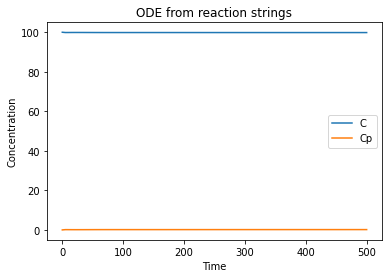

In [38]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

t = np.linspace(0, 500, 100)
func = reactions_to_ode_func(reactions, species, parameters)
sol = odeint(func, y0, t, args=tuple(parameter_values))

# Plot
for i, s in enumerate(species):
    if s == 'C' or s == 'Cp':
        plt.plot(t, sol[:, i], label=s)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("ODE from reaction strings")
plt.show()